In [4]:
from google.colab import files
uploaded = files.upload()

Saving ICUSTAYS.csv.gz to ICUSTAYS.csv.gz


In [5]:
# 1. Load Data and Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

path_admissions = 'ADMISSIONS.csv.gz'
path_patients = 'PATIENTS.csv.gz'
path_icustays = 'ICUSTAYS.csv.gz'
path_diagnoses = 'DIAGNOSES_ICD.csv.gz'

df_adm = pd.read_csv(path_admissions)
df_pat = pd.read_csv(path_patients)
df_icu = pd.read_csv(path_icustays)
df_diag = pd.read_csv(path_diagnoses)
print("Data loaded successfully.")



Data loaded successfully.


In [6]:
# 2. Feature Engineering & Initial Visualization

df_merged = pd.merge(df_adm, df_icu, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
df_final = pd.merge(df_merged, df_pat, on='SUBJECT_ID', how='inner')

# Calculate Patient Age at Admission
df_final['ADMITTIME'] = pd.to_datetime(df_final['ADMITTIME'])
df_final['DOB'] = pd.to_datetime(df_final['DOB'])
df_final['AGE'] = df_final['ADMITTIME'].dt.year - df_final['DOB'].dt.year
df_final.loc[df_final['AGE'] > 89, 'AGE'] = 90
print("\nCalculated patient age at admission")

# Engineer Diagnosis Features
print("\nConvert features from diagnosis codes")
df_diag['ICD9_CODE'] = df_diag['ICD9_CODE'].str.strip()
df_diag.dropna(subset=['ICD9_CODE'], inplace=True)
df_diag['ICD9_CODE'] = df_diag['ICD9_CODE'].str.replace('.', '', regex=False)

icd9_ranges = {
    (1, 139): 'Infectious and Parasitic Diseases', (140, 239): 'Neoplasms',
    (240, 279): 'Endocrine/Metabolic', (280, 289): 'Blood and Blood-Forming Organs',
    (290, 319): 'Mental Disorders', (320, 389): 'Nervous System',
    (390, 459): 'Circulatory System', (460, 519): 'Respiratory System',
    (520, 579): 'Digestive System', (580, 629): 'Genitourinary System',
    (630, 679): 'Pregnancy/Childbirth', (680, 709): 'Skin and Subcutaneous Tissue',
    (710, 739): 'Musculoskeletal System', (740, 759): 'Congenital Anomalies',
    (760, 779): 'Perinatal Conditions', (780, 799): 'Symptoms and Ill-defined Conditions',
    (800, 999): 'Injury and Poisoning'
}

def map_icd9_to_category(code):
    try:
        if code.startswith('E'): return 'External Causes of Injury'
        if code.startswith('V'): return 'Factors Influencing Health Status'
        code_num = int(code[:3])
        for r, cat in icd9_ranges.items():
            if r[0] <= code_num <= r[1]: return cat
    except (ValueError, TypeError): return 'Unknown'
    return 'Unknown'

df_diag['DIAGNOSIS_CATEGORY'] = df_diag['ICD9_CODE'].apply(map_icd9_to_category)
diag_pivot = df_diag.pivot_table(index='HADM_ID', columns='DIAGNOSIS_CATEGORY', aggfunc='size', fill_value=0)
df_final = pd.merge(df_final, diag_pivot, on='HADM_ID', how='left')
df_final[diag_pivot.columns] = df_final[diag_pivot.columns].fillna(0)
print("\nCreated diagnosis category counts.")



Calculated patient age at admission

Convert features from diagnosis codes

Created diagnosis category counts.


Filtered dataset to 45706 admissions in MICU, SICU, or CSRU/TSICU.

Created new binary target variable 'TARGET':
TARGET
1    24618
0    21088
Name: count, dtype: int64

Cleaned Ethinicity


/tmp/ipython-input-7-1594016671.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_binary.loc[:, 'TARGET'] = df_binary['FIRST_CAREUNIT'].replace({


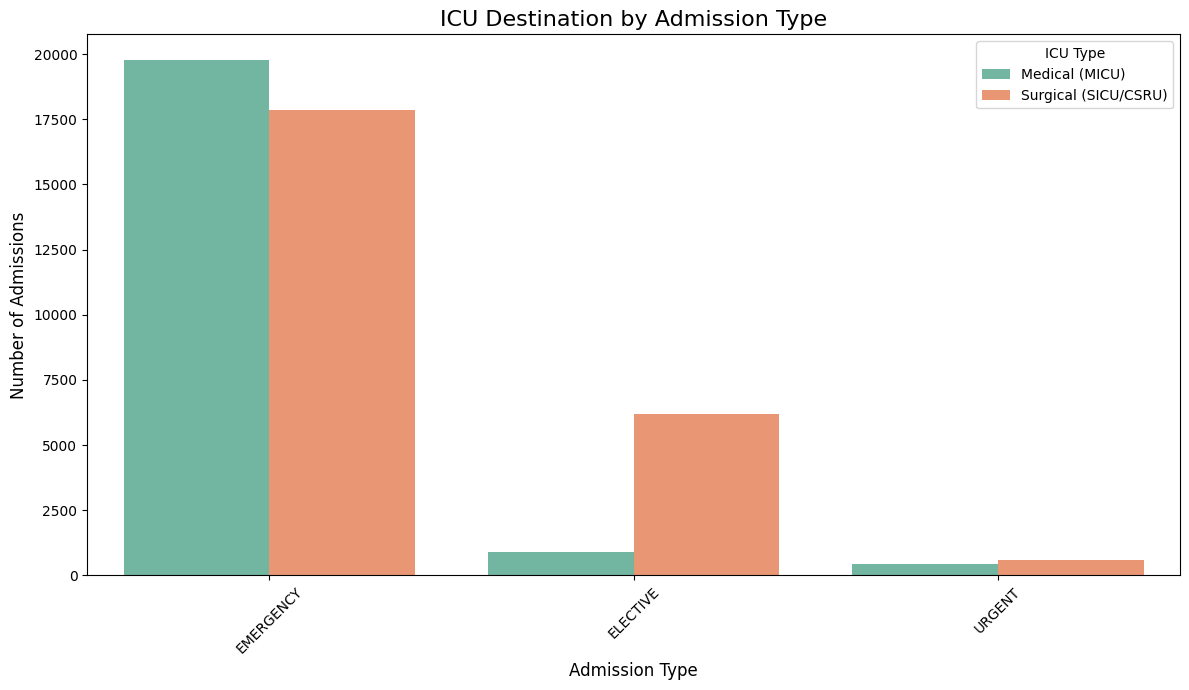

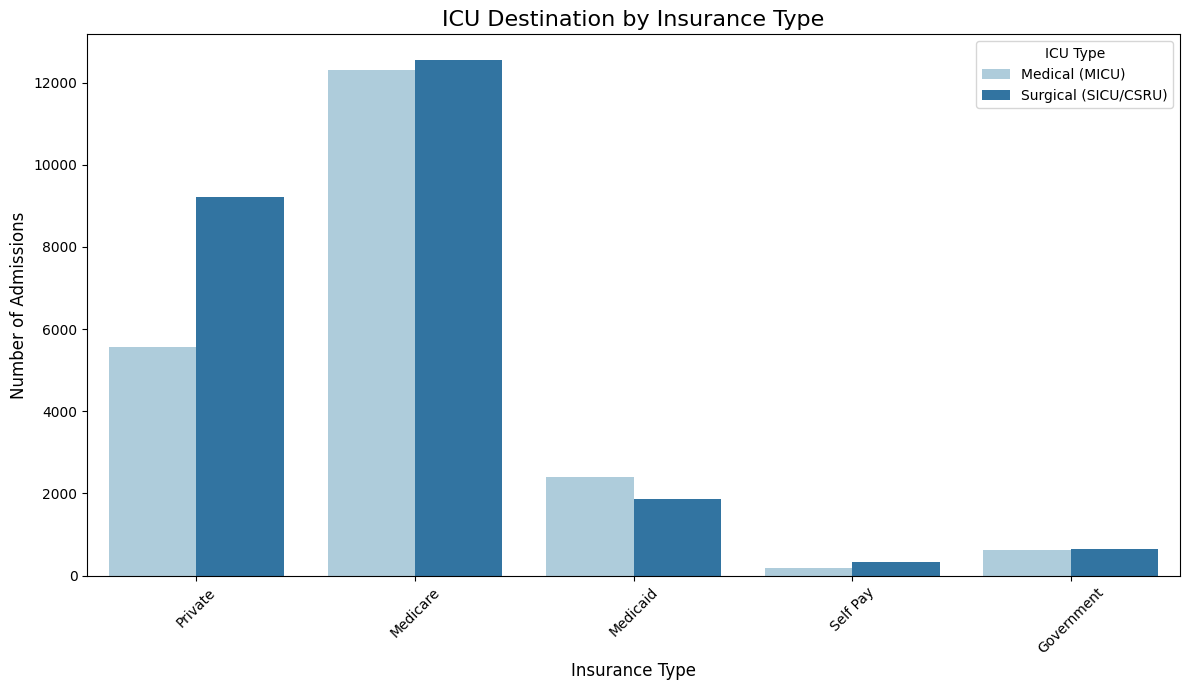


Data split into 36564 training samples and 9142 testing samples.
Data Cleaning and Splitting Complete.


In [7]:

# 3. Data Cleaning, Splitting

# Filter for the Binary Classification Task
# We will predict Medical (MICU) vs. Surgical/Procedural (SICU/CSRU)
relevant_units = ['MICU', 'SICU', 'CSRU', 'TSICU']
df_binary = df_final[df_final['FIRST_CAREUNIT'].isin(relevant_units)].copy()
print(f"Filtered dataset to {len(df_binary)} admissions in MICU, SICU, or CSRU/TSICU.")

# Create the New Binary Target Variable
# 1 for Surgical, 0 for Medical
df_binary.loc[:, 'TARGET'] = df_binary['FIRST_CAREUNIT'].replace({
    'MICU': 0,
    'SICU': 1,
    'TSICU': 1,
    'CSRU': 1
})
print("\nCreated new binary target variable 'TARGET':")
print(df_binary['TARGET'].value_counts())

# Select Final Features and Target
base_features = ['ADMISSION_TYPE', 'INSURANCE', 'ETHNICITY', 'GENDER', 'AGE']
diag_features = list(diag_pivot.columns)
final_feature_cols = base_features + diag_features

X = df_binary[final_feature_cols]
y = df_binary['TARGET']

# Handle Missing Values
for col in X.select_dtypes(include=['object']).columns:
    X.loc[:, col] = X[col].fillna(X[col].mode()[0])

X.loc[:, 'ETHNICITY'] = X['ETHNICITY'].replace(regex=r'^WHITE.*', value='WHITE')
X.loc[:, 'ETHNICITY'] = X['ETHNICITY'].replace(regex=r'^BLACK.*', value='BLACK/AFRICAN AMERICAN')
X.loc[:, 'ETHNICITY'] = X['ETHNICITY'].replace(regex=r'^ASIAN.*', value='ASIAN')
X.loc[:, 'ETHNICITY'] = X['ETHNICITY'].replace(regex=r'^HISPANIC.*', value='HISPANIC/LATINO')
other_ethnicities = [
    'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER', 'UNABLE TO OBTAIN',
    'MULTI RACE ETHNICITY', 'OTHER', 'AMERICAN INDIAN/ALASKA NATIVE',
    'PORTUGUESE', 'SOUTH AMERICAN', 'CARIBBEAN ISLAND',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'MIDDLE EASTERN',
    'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE'
]
X.loc[X['ETHNICITY'].isin(other_ethnicities), 'ETHNICITY'] = 'OTHER/UNKNOWN'
print("\nCleaned Ethinicity")

vis_df = X.copy()
vis_df['TARGET'] = y.map({0: 'Medical (MICU)', 1: 'Surgical (SICU/CSRU)'})

# Admission Type vs. ICU Destination
plt.figure(figsize=(12, 7))
sns.countplot(data=vis_df, x='ADMISSION_TYPE', hue='TARGET', palette='Set2')
plt.title('ICU Destination by Admission Type', fontsize=16)
plt.xlabel('Admission Type', fontsize=12)
plt.ylabel('Number of Admissions', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='ICU Type')
plt.tight_layout()
plt.show()

# Insurance Type vs. ICU Destination
plt.figure(figsize=(12, 7))
sns.countplot(data=vis_df, x='INSURANCE', hue='TARGET', palette='Paired')
plt.title('ICU Destination by Insurance Type', fontsize=16)
plt.xlabel('Insurance Type', fontsize=12)
plt.ylabel('Number of Admissions', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='ICU Type')
plt.tight_layout()
plt.show()

X_encoded = pd.get_dummies(X, drop_first=True)

# Split Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nData split into {len(X_train)} training samples and {len(X_test)} testing samples.")
print("Data Cleaning and Splitting Complete.")



In [8]:
# 4. Machine Learning Models
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Gaussian Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    print(f"\nTraining {name} Classifier...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

print("Model training complete.")


Training K-Nearest Neighbors Classifier...
K-Nearest Neighbors Accuracy: 0.7099

Training Gaussian Naive Bayes Classifier...
Gaussian Naive Bayes Accuracy: 0.6545

Training XGBoost Classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:49:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7748
Model training complete.


In [9]:

# 5. Model Fine-tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.001],
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

print("Starting GridSearchCV")
grid_search.fit(X_train, y_train)

print("\nGridSearchCV Complete.")
print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search.best_score_:.4f}")

best_xgb_model = grid_search.best_estimator_

Starting GridSearchCV
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:50:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



GridSearchCV Complete.
Best Parameters Found: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
Best Cross-validation Accuracy: 0.7639



Final Tuned Model Accuracy on Test Set: 0.7788

Classification Report:
                      precision    recall  f1-score   support

      Medical (MICU)       0.75      0.79      0.77      4218
Surgical (SICU/CSRU)       0.81      0.77      0.79      4924

            accuracy                           0.78      9142
           macro avg       0.78      0.78      0.78      9142
        weighted avg       0.78      0.78      0.78      9142


Confusion Matrix:


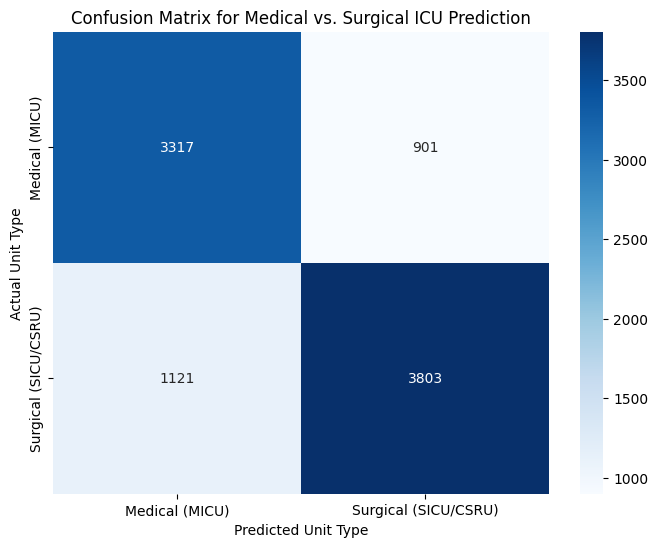


Visualizing Top Most Important Features:


/tmp/ipython-input-14-1993165429.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')


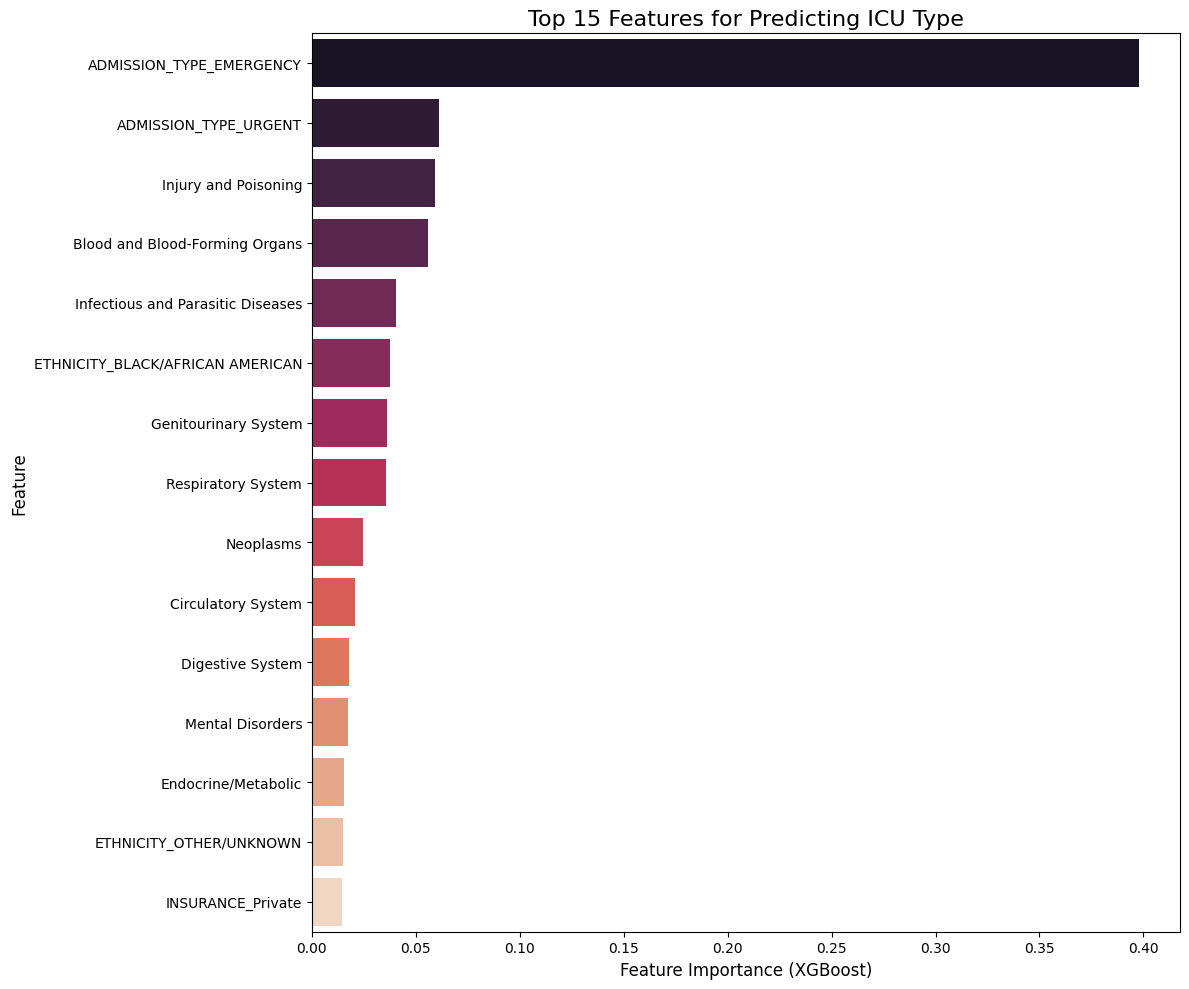

In [14]:
# 6. Evaluation of Final Model

y_pred_final = best_xgb_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\nFinal Tuned Model Accuracy on Test Set: {final_accuracy:.4f}")

print("\nClassification Report:")
target_names_for_report = ['Medical (MICU)', 'Surgical (SICU/CSRU)']
print(classification_report(y_test, y_pred_final, target_names=target_names_for_report))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_for_report,
            yticklabels=target_names_for_report)
plt.title('Confusion Matrix for Medical vs. Surgical ICU Prediction')
plt.ylabel('Actual Unit Type')
plt.xlabel('Predicted Unit Type')
plt.show()

print("\nVisualizing Top Most Important Features:")
feature_importances = best_xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')
plt.title('Top 15 Features for Predicting ICU Type', fontsize=16)
plt.xlabel('Feature Importance (XGBoost)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()
